# Derivatives

(C) Pietro Vischia, 2025
pietro.vischia@cern.ch

We have seen during the lecture that computer derivatives are crucial, particularly for things like machine learning.

In this notebook we will compare the main ways of computing derivatives, and will come up with a basic---but perfectly working---implementation of automatic differentiation.


<img src="autodiff_edit.png" alt="drawing" width="50%"/>
Image from Güneş Baydin et al, [JMLR 18 (2018) 1--43](https://jmlr.org/papers/v18/17-468.html)


We first import a few useful libraries.

- `math` provides, among other things, trigonometrical functions. In this tutorial, we are interested in `sin` and `cos`.
- `matplotlib` is a plotting library, we will use it to make plots

In [32]:
import math
import matplotlib.pyplot as plt

Let's begin by defining a simple function of one variable

In [33]:
def f_math(x):
    return 2 + 3*math.sin(x) + x**3


And let's plot it

In [34]:
x = np.linspace(-10,10, 10)
plt.plot(x, f_math(x))

TypeError: only length-1 arrays can be converted to Python scalars

Why does it fail? It turns out that the simple `math` library doesn't natively support vector operations.
To make it work, we need to loop on the elements of `x`

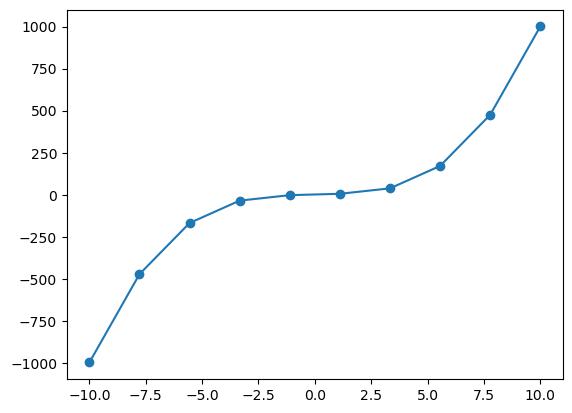

In [35]:
plt.plot(x, [f_math(xi) for xi in x])
plt.scatter(x, [f_math(xi) for xi in x])

However, who wants to do that?

`numpy` is a library that provides more control on vector operations than the one provided by the basic python arrays.

Let's import the library, redefine and re-plot the function.

In [39]:
import numpy as np

In [38]:
def f(x):
    return 2 + 3*np.sin(x) + x*x*x

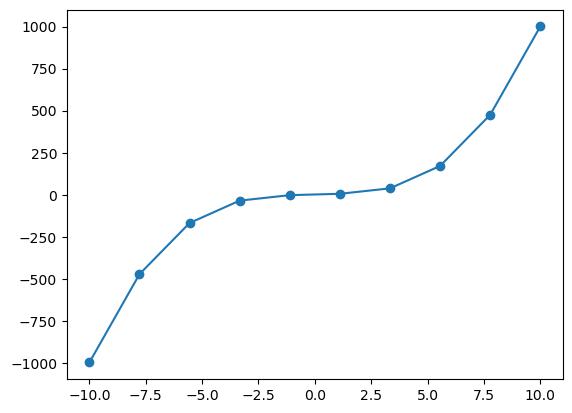

In [40]:
plt.plot(x, f(x))
plt.scatter(x, f(x))

We will also define our own plotting function, to have points and lines at the same time

In [49]:
def myplot(x, y, label=''):
    plt.plot(x, y, label=label)
    plt.scatter(x, y)

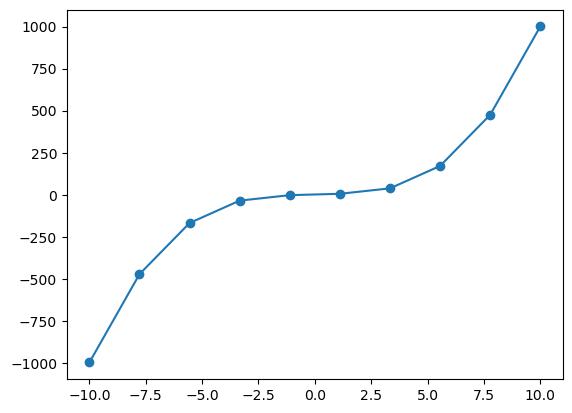

In [50]:
myplot(x, f(x))

Now we can compute and plot the analytical derivative of `f`

In [51]:
def anal_deriv(x):
    return 3*np.cos(x)+ 3*x**2
    

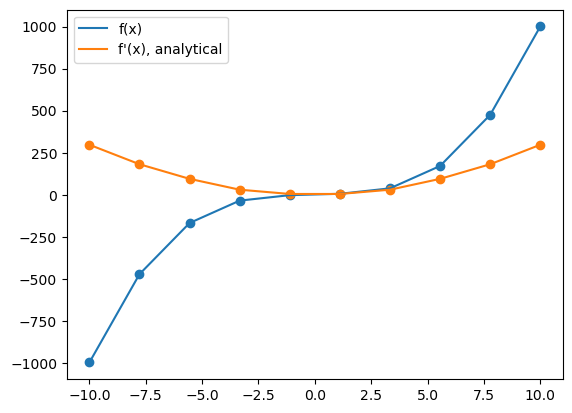

In [52]:
myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
plt.legend()

We can plot the function to an arbitrary level of precision (up to machine precision), by evaluating the functions in more points


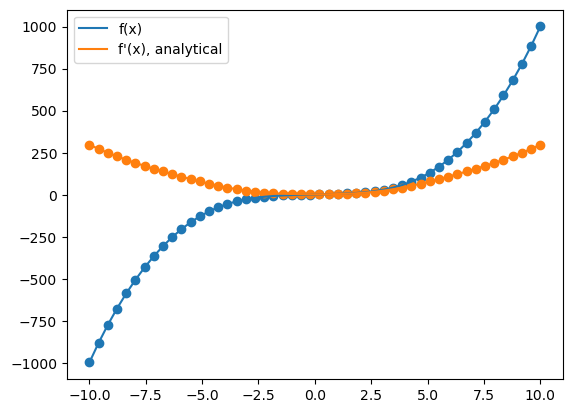

In [57]:
x = np.linspace(-10,10, 50)

myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
plt.legend()

Let's go back to our 10 points

In [150]:
x = np.linspace(-10,10, 10)


Symbolic differentiation is based on software that interprets the expression obtaining its symbolic form. Any additional operation, like for instance taking the derivative of the function, is performed by acting on the symbolic expression.

We will use the package `sympy` to translate our function into a symbolic expression, and to then calculate the symbolic derivative

In [59]:
import sympy

In [60]:
symbolic_x = sympy.symbols('x')
symbolic_func = f(symbolic_x)
symbolic_func

sym_y = sympy.lambdify(symbolic_x,symbolic_func)(x)


TypeError: loop of ufunc does not support argument 0 of type Symbol which has no callable sin method

What is happening? `sympy` does not recognize `numpy`-specific expressions, so we will have to revert back to using our basic expression based on the `math`library

In [61]:
import sympy

symbolic_x = sympy.symbols('x')
symbolic_func = f_math(symbolic_x)
symbolic_func

sym_y = sympy.lambdify(symbolic_x,symbolic_func)(x)


TypeError: Cannot convert expression to float

However, not even that is working: `sympy` seems to be able to access `math` functions, but having represented `x` in symbolic form prevents it to be passed to `math.sin`, which expects a float.

As it often happens, the solution is to use `sympy`'s own definition of `sin`.

In [70]:
def f_sympy(x):
    return 2 + 3*sympy.sin(x)+ x**3
x_symb = sympy.symbols('x')
f_symb = f_sympy(x_symb)
f_symb

x**3 + 3*sin(x) + 2

Note that `sympy` reorders the terms according to its own rules.

We can now let the software calculate the symbolic derivative very easily

In [71]:
symb_deriv = f_symb.diff(x_symb)
symb_deriv

3*x**2 + 3*cos(x)

Now let's plot the symbolic derivative.
In order to obtain an array of numbers (which is what `matplotlib` expects), we will evaluate the function on our `x` by converting the symbolic expression into a python `lambda` function

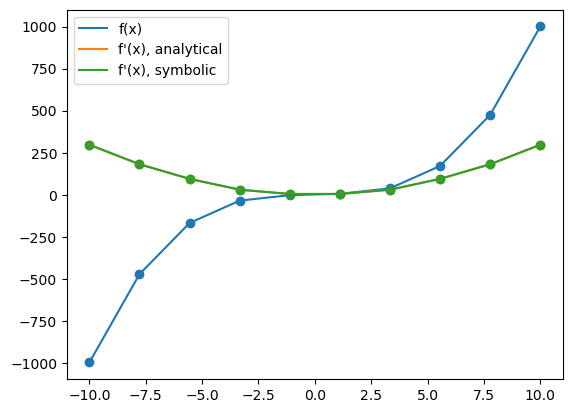

In [74]:
myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
plt.legend()

The symbolic derivative always matches with the exact derivative!

This is always true, no matter whether you evaluate it in more points or less points:

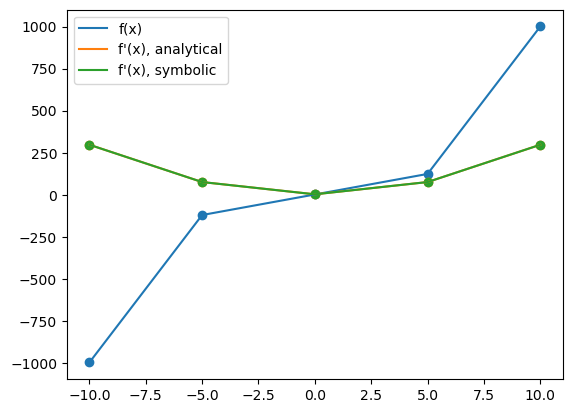

In [96]:
x_fewpoints = np.linspace(-10,10, 5)
myplot(x_fewpoints, f(x_fewpoints), label="f(x)")
myplot(x_fewpoints, anal_deriv(x_fewpoints), label="f'(x), analytical")
myplot(x_fewpoints, sympy.lambdify(x_symb,symb_deriv)(x_fewpoints), label="f'(x), symbolic")
plt.legend()

However, symbolic differentiation applied to long or complicated expressions tends to result in huge derivative expressions that are slow to evaluate 

In [97]:
def complicated_f(x):
    return 2 + sympy.atan(x)*sympy.sin(x)+sympy.cos(x+3)*sympy.log(x)**3
x_symb = sympy.symbols('x')
f_comp_symb = complicated_f(x_symb)
f_comp_symb


log(x)**3*cos(x + 3) + sin(x)*atan(x) + 2

In [98]:
comp_symb_deriv = f_comp_symb.diff(x_symb)
comp_symb_deriv

-log(x)**3*sin(x + 3) + cos(x)*atan(x) + sin(x)/(x**2 + 1) + 3*log(x)**2*cos(x + 3)/x

Let's now calculate numerical derivatives, using the finite differences method.

Exercise: you could also modify the formula to use the midpoint method, that provides a somehow better precision.

In [101]:
def num_deriv(x, epsilon):
    return (f(x+epsilon)-f(x))/epsilon

We can now compare the derivatives we obtained. We will not plot the function `f(x)`, so that we can zoom better on the behaviour of the derivatives

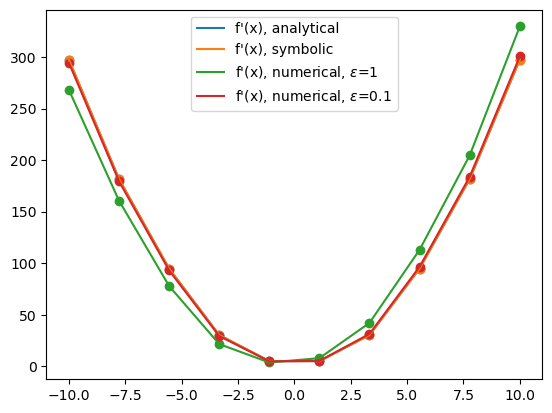

In [116]:
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
epsilon=1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=0.1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()

Numerical derivatives differ significatively from the exact derivatives when the step $\epsilon$ is large.
The smaller the step, the better is the numerical approximation.

However, if $\epsilon$ becomes too small...

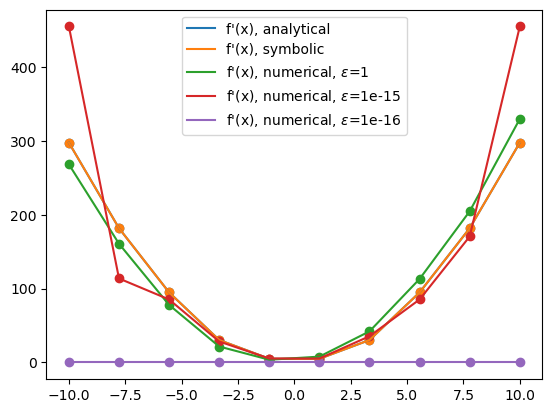

In [123]:
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
epsilon=1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()

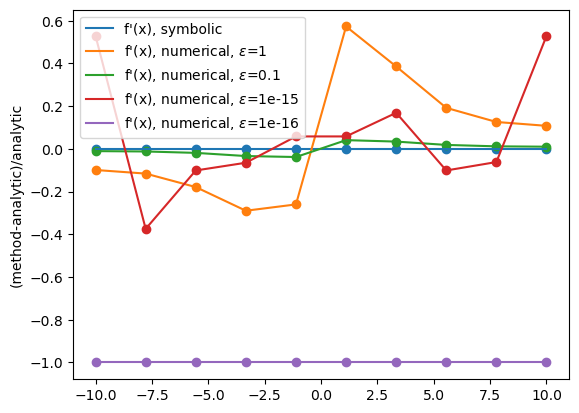

In [126]:
myplot(x, (sympy.lambdify(x_symb,symb_deriv)(x)-anal_deriv(x))/anal_deriv(x), label="f'(x), symbolic")
epsilon=1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=0.1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()


plt.ylabel("(method-analytic)/analytic")
plt.legend()

All that remains is now to examine automatic differentiation and to see how it compares with the methods above!

We could jump directly into using one of the awesome autodiff packages that are on the market, but what would be the fun in that?

## Let's try to implement automatic differentiaton by ourselves!

### Dual numbers

We have seen that dual numbers, i.e. numbers that can be written as $a+b\epsilon$, where $\epslion^2=0$, can be used to represent a small perturbation $P(x+\epsilon)$ of a polynomial function $P(x)$. Developing the expression, we soon obtain the important result

$P(x+\epsilon) = \ldots = P(x) + \epsilon \frac{dP(x)}{dx}$.

Generalizing, we can use dual numbers to rewrite a function of a real number as a function that takes a dual number as an input, and holds the value of the function in the principal part of the dual number, and its derivative in the dual part of the dual number:

$f(a + b\epsilon) = f(a) +\epsilon f'(a)$

### Operator overloading

To use this property of dual numbers, we need a way of converting our code in such a way that each function that normally would take a `float` as an input now takes a dual number.

In python (or in C++, or in pretty much any object-oriented language) this is very easy: we can define a class that uses dual numbers arithmetic, and then we simply feed a function a dual number instead of a float.

We only have to take good care to reimplement any operator of the type class (multiplication, addition, subtraction, etc) that is present in the functions we want to feed this dual numbers to! We will also have to reimplement any accessory function like `sin(x)`, and rewrite our function to use our new implementation.

Exercise: can you figure out what to put into the missing part of the class below?
Attention: is the expression for 

In [155]:
class DualNumber:
        def __init__(self, primal, tangent=0):
                self.primal=primal
                self.tangent=tangent
        def __add__(self, other):
                return ...
        def __rmul__(self, a):
                return ...
        def __mul__(self, other):
                return ...

def dualsin(val):
        return DualNumber(...)


def f_withduals(xd):
        return 2*xd + 3*sin(xd) + xd*xd*xd

xd = DualNumber(1.,1.)
z = f_withduals(xd)

print("z =", z.primal)
print("dc/dx =", z.tangent)

TypeError: unsupported operand type(s) for +: 'ellipsis' and 'ellipsis'

Try to do it yourself!!!
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.



...but you can also simply use the full implementation below.

Note two things:
- we had to replace the floats `2`and `3` in the function with their dual counterpart. This is necessary.
- we modified the return value of the function to support array inputs and outputs. This is not necessary, we did it just to be able to then plot the autodiff derivative in the same way as we plot the other types of derivatives.

In [172]:
class DualNumber:
        def __init__(self, primal, tangent=0):
                self.primal=primal
                self.tangent=tangent
        def __add__(self, other):
                return DualNumber(  
                        self.primal+other.primal, self.tangent+other.tangent)
        def __rmul__(self, a):
                return DualNumber(
                        self.primal*a, self.tangent*a)
        def __mul__(self, other):
                return DualNumber(
                        self.primal*other.primal, self.primal*other.tangent+ self.tangent*other.primal)
def sin(val):
        return DualNumber(
                math.sin(val.primal),
                math.cos(val.primal)*val.tangent)



In [181]:
def f_withduals(xs):
    if isinstance(xs, np.ndarray):
        return np.array( [ DualNumber(2,0) + DualNumber(3, 0)*sin(xi)+ xi*xi*xi for xi in xs] )
    else:
        return DualNumber(2,0) + DualNumber(3, 0)*sin(xs) + xs*xs*xs

print( type(np.array([1])))
xd = DualNumber(1.,1.)
z = f_withduals(xd)

print("z =", z.primal, ", to be compared with", f(1))
print("df(x)/dx =", z.tangent, ", to be compared with", anal_deriv(1))


<class 'numpy.ndarray'>
z = 5.524412954423689 , to be compared with 5.524412954423689
df(x)/dx = 4.620906917604419 , to be compared with 4.620906917604419


The autodiff derivative matches perfectly the analytical derivative.

### Automatic differentiation provides exact numerical derivatives.

Let's now see what happens if we set the derivative of the input to zero:

In [183]:
xd = DualNumber(1.,0)
z = f_withduals(xd)

print("z =", z.primal, ", to be compared with", f(1))
print("df(x)/dx =", z.tangent, ", to be compared with", anal_deriv(1))


z = 5.524412954423689 , to be compared with 5.524412954423689
df(x)/dx = 0.0 , to be compared with 4.620906917604419


In automatic differentiation, for derivatives to be propagated correctly we must provide an input derivative of $1$, corresponding to the first differentiation in the chain rule, i.e. the derivative of the input with respect to itself).

z = 10.909297426825681
dc/dx = 2.909297426825682


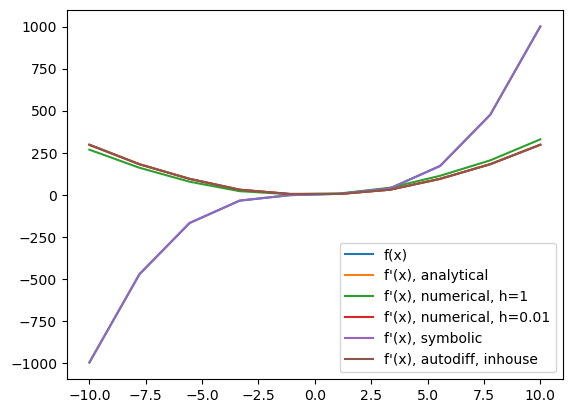

In [27]:


plt.plot(x, f(x), label="f(x)")
plt.plot(x, anal_deriv(x), label="f'(x), analytical")
plt.plot(x, num_deriv(x, 1), label="f'(x), numerical, h=1")
plt.plot(x, num_deriv(x, 0.01), label="f'(x), numerical, h=0.01")
plt.plot(x, sympy.lambdify(symbolic_x,symbolic_func)(x), label="f'(x), symbolic")
plt.plot(x, [xi.tangent for xi in f_withduals(x_dual)], label="f'(x), autodiff, inhouse")
plt.legend()

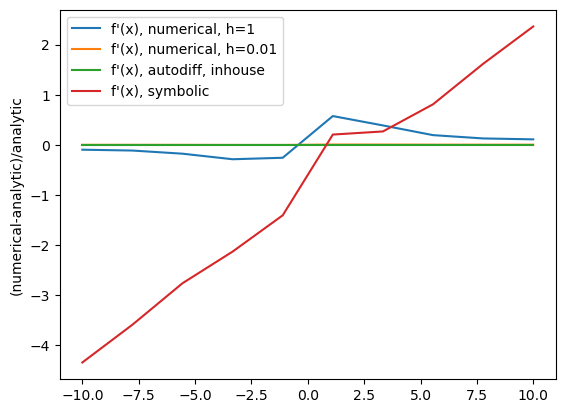

In [28]:
plt.plot(x, (num_deriv(x, 1)-anal_deriv(x))/anal_deriv(x), label="f'(x), numerical, h=1")
plt.plot(x, (num_deriv(x, 0.01)-anal_deriv(x))/anal_deriv(x), label="f'(x), numerical, h=0.01")
plt.plot(x, ([xi.tangent for xi in f_withduals(x_dual)]-anal_deriv(x))/anal_deriv(x), label="f'(x), autodiff, inhouse")
plt.plot(x, (sympy.lambdify(symbolic_x,symbolic_func)(x)-anal_deriv(x))/anal_deriv(x), label="f'(x), symbolic")

plt.ylabel("(numerical-analytic)/analytic")
plt.legend()

In [29]:
import torch

In [30]:
xt = torch.tensor(x, requires_grad=False)

f_torch = 2 + 3*torch.sin(xt)+ xt**3

In [31]:
f_torch.backward(torch.ones_like(f_torch))
print(xt.grad)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [32]:
xt = torch.tensor(x, requires_grad=True)

f_torch = 2 + 3*torch.sin(xt)+ xt**3

In [33]:
f_torch.backward(torch.ones_like(f_torch))
print(xt.grad)

tensor([297.4828, 181.7099,  94.8329,  30.3883,   5.0347,   5.0347,  30.3883,
         94.8329, 181.7099, 297.4828], dtype=torch.float64)


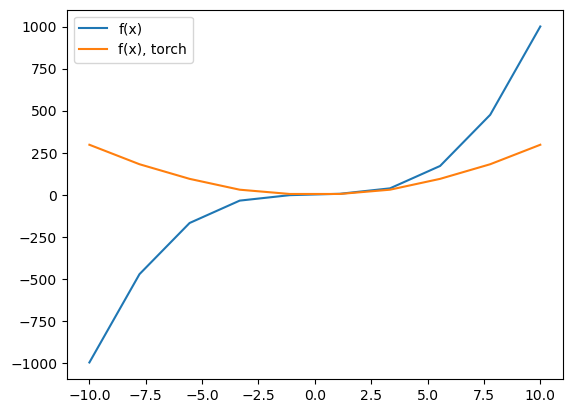

In [34]:
    
plt.plot(x, f(x), label="f(x)")
plt.plot(xt.detach().numpy(), xt.grad.detach().numpy(), label="f(x), torch")
plt.legend()

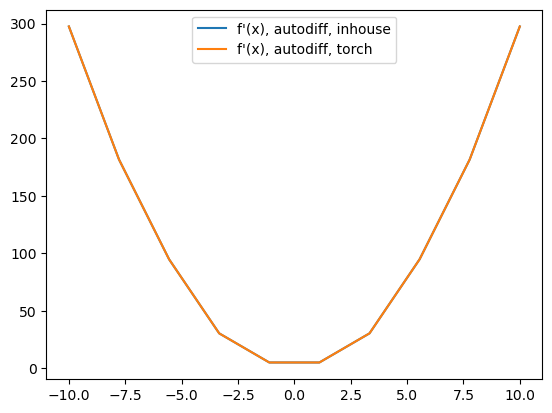

In [35]:
plt.plot(x, [xi.tangent for xi in f_withduals(x_dual)], label="f'(x), autodiff, inhouse")
plt.plot(xt.detach().numpy(), xt.grad, label="f'(x), autodiff, torch")

plt.legend()

Not bad!!!

What about timing?



In [185]:
def func(x,y):
        return 2*x + x*sin(y) + y*y*y
x = DualNumber(1., 1.)
y = DualNumber(2.)
z = func(x, y)
print("z =", z.primal)
print("dc/dx =", z.tangent)

z = 10.909297426825681
dc/dx = 2.909297426825682


In [36]:
from timeit import timeit


In [39]:
print("Function:", timeit('f(x)', globals=globals()))
print("Analytic derivative:", timeit('anal_deriv(x)', globals=globals()))
print("Numerical derivative, h=1:", timeit('num_deriv(x, 1)', globals=globals()))
print("Numerical derivative, h=0.01:", timeit('num_deriv(x, 0.01)', globals=globals()))
#print("Symbolic derivative:", timeit('sympy.lambdify(symbolic_x,symbolic_func)(x)', globals=globals()))
print("Autodiff, inhouse:", timeit('[xi.tangent for xi in f_withduals(x_dual)]', globals=globals()))
print("Autodiff, torch:", timeit('f_torch.backward(torch.ones_like(f_torch));xt.grad', globals=globals()))


Function: 1.9745324999676086
Analytic derivative: 1.7156480409903452
Numerical derivative, h=1: 5.354405332996976
Numerical derivative, h=0.01: 5.027340958011337
Autodiff, inhouse: 22.20946433302015


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [41]:
xtn = torch.tensor(x, requires_grad=True)
f_torchn = 2 + 3*torch.sin(xtn)+ xtn**3

print("Function:", timeit('f(x)', globals=globals()))
print("Analytic derivative:", timeit('anal_deriv(x)', globals=globals()))
print("Numerical derivative, h=1:", timeit('num_deriv(x, 1)', globals=globals()))
print("Numerical derivative, h=0.01:", timeit('num_deriv(x, 0.01)', globals=globals()))
#print("Symbolic derivative:", timeit('sympy.lambdify(symbolic_x,symbolic_func)(x)', globals=globals()))
print("Autodiff, inhouse:", timeit('[xi.tangent for xi in f_withduals(x_dual)]', globals=globals()))
print("Autodiff, torch:", timeit('f_torchn.backward(torch.ones_like(f_torchn));xtn.grad', globals=globals()))


Function: 1.9933225000277162
Analytic derivative: 1.6866355419624597
Numerical derivative, h=1: 5.074446416052524
Numerical derivative, h=0.01: 4.925972709024791
Autodiff, inhouse: 21.712582834006753


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [49]:
xt = torch.tensor(x, requires_grad=True).to(torch.device("mps"))

def anal_d(x):
    return anal_deriv(x)
def num_d(x, h):
    return num_deriv(x,h)
def adin_d(x_dual):
    return [xi.tangent for xi in f_withduals(x_dual)] 
def adtorch_d(xt):
    f_torchn = 2 + 3*torch.sin(xtn)+ xtn**3
    f_torchn.backward(torch.ones_like(f_torchn))

print("Function:", timeit('f(x)', globals=globals()))
print("Analytic derivative:", timeit('anal_d(x)', globals=globals()))
print("Numerical derivative, h=1:", timeit('num_d(x, 1)', globals=globals()))
print("Numerical derivative, h=0.01:", timeit('num_d(x, 0.01)', globals=globals()))
#print("Symbolic derivative:", timeit('sympy.lambdify(symbolic_x,symbolic_func)(x)', globals=globals()))
print("Autodiff, inhouse:", timeit('adin_d(x_dual)', globals=globals()))
print("Autodiff, torch:", timeit('adtorch_d(xt);xt.grad', globals=globals()))


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [51]:
!pip install torchviz

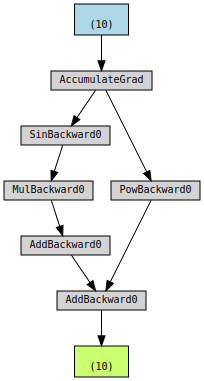

In [54]:
from torchviz import make_dot

make_dot(f_torch)



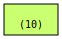

In [53]:
make_dot(xt)

Let's start by defining a simple function of two variables, the same we have seen during the lecture


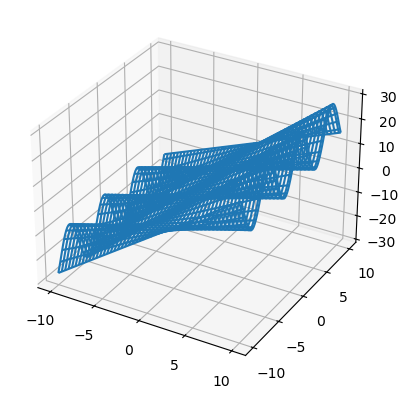

In [22]:

def f(x0, x1):
    return 2*x0 + x0*np.sin(x1)+ (x1**3)/1000
    
x0 = np.linspace(-10,10, 100)
x1 = np.linspace(-10,10,100)
X0, X1 = np.meshgrid(x0, x1)
Y = f(X0, X1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_wireframe(X0, X1, Y, color="C0")